# DTW (Dynamic Time Warping)による株価予測のデモ

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from pandas_datareader import data as pdr
import mplfinance as mpf
from datetime import date, datetime, timedelta

## 関数の定義

In [2]:
def normalize(ts):
    return (ts - ts.min()) / (ts.max() - ts.min())

# 最小値0, 最大値1で標準化した上でfastdtw()により非類似度を計算する
def dtw_distance(ts1, ts2):
    ts1_normalized = normalize(ts1)
    ts2_normalized = normalize(ts2)
    distance, _ = fastdtw(ts1_normalized.reshape(-1, 1), ts2_normalized.reshape(-1, 1), dist=euclidean)
    return distance

def find_most_similar_pattern(n_days):
    current_window = price_data_pct_change[-n_days:].values
    # 初期値として(∞,-1)からなる5つのタプルを生成
    min_distances = [(float('inf'), -1) for _ in range(5)]
    # 全ての開始時点についてのループを5回まわすことにより距離の小さい5つのケースを抽出する
    for start_index in range(len(price_data_pct_change) - 2 * n_days - subsequent_days):
        past_window = price_data_pct_change[start_index:start_index + n_days].values
        distance = dtw_distance(current_window, past_window)
        for i, (min_distance, _) in enumerate(min_distances):
            if distance < min_distance:
                min_distances[i] = (distance, start_index)
                break
    return min_distances

## 株価データの獲得

In [3]:
# yahooサイトからデータをダウンロード
ticker = '9983.T'
end_date = datetime.today()
# 分析に用いるデータ期間を指定する
start_date = end_date - timedelta(days=3650)
yf.pdr_override()
data = pdr.get_data_yahoo(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# 終値を価格データとする
price_data = data['Close']
# (y(t)-y(t-1))/y(t-1) の変化率データに変換する
price_data_pct_change = price_data.pct_change().dropna()

In [5]:
# 3通りの窓の期間について評価する 
days_to = [15, 20, 30]
# 現在時点から何日先までの予測値をプロットするかを指定する
subsequent_days = 20

## 過去の類似パターンを抽出して描画

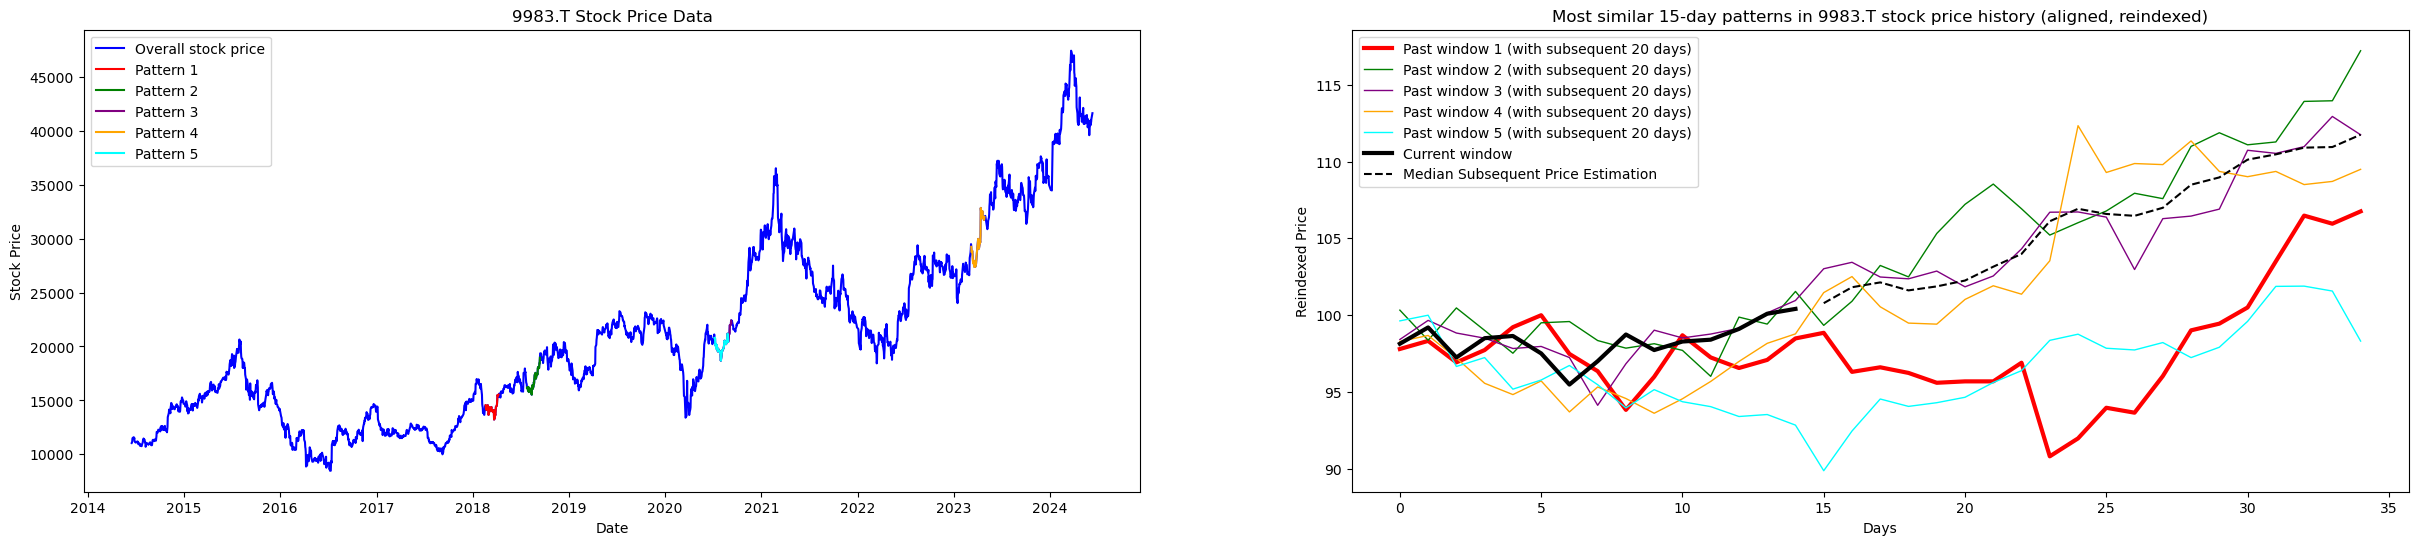

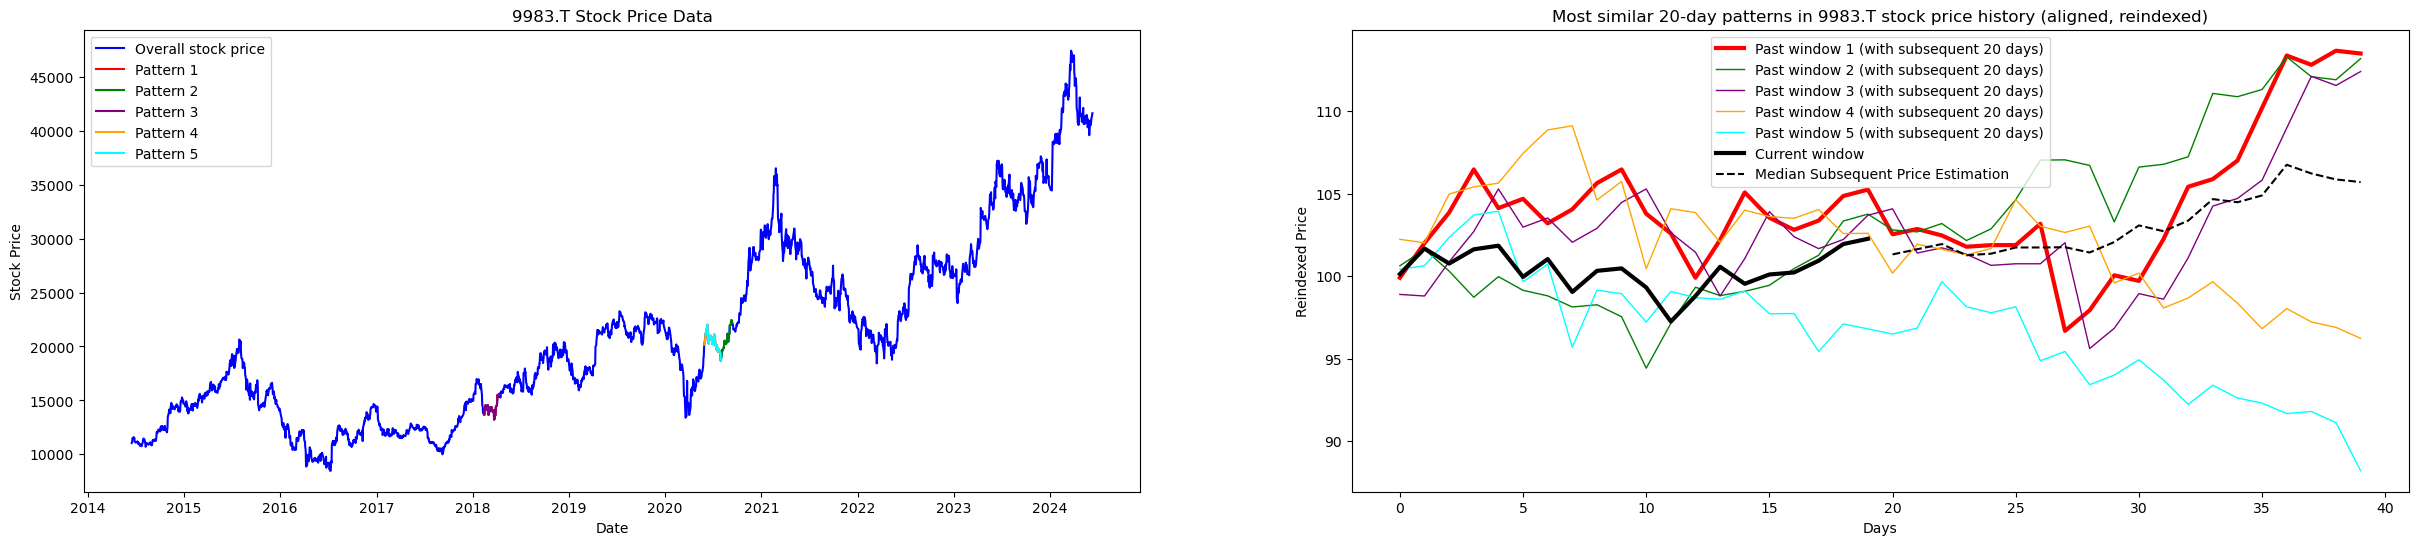

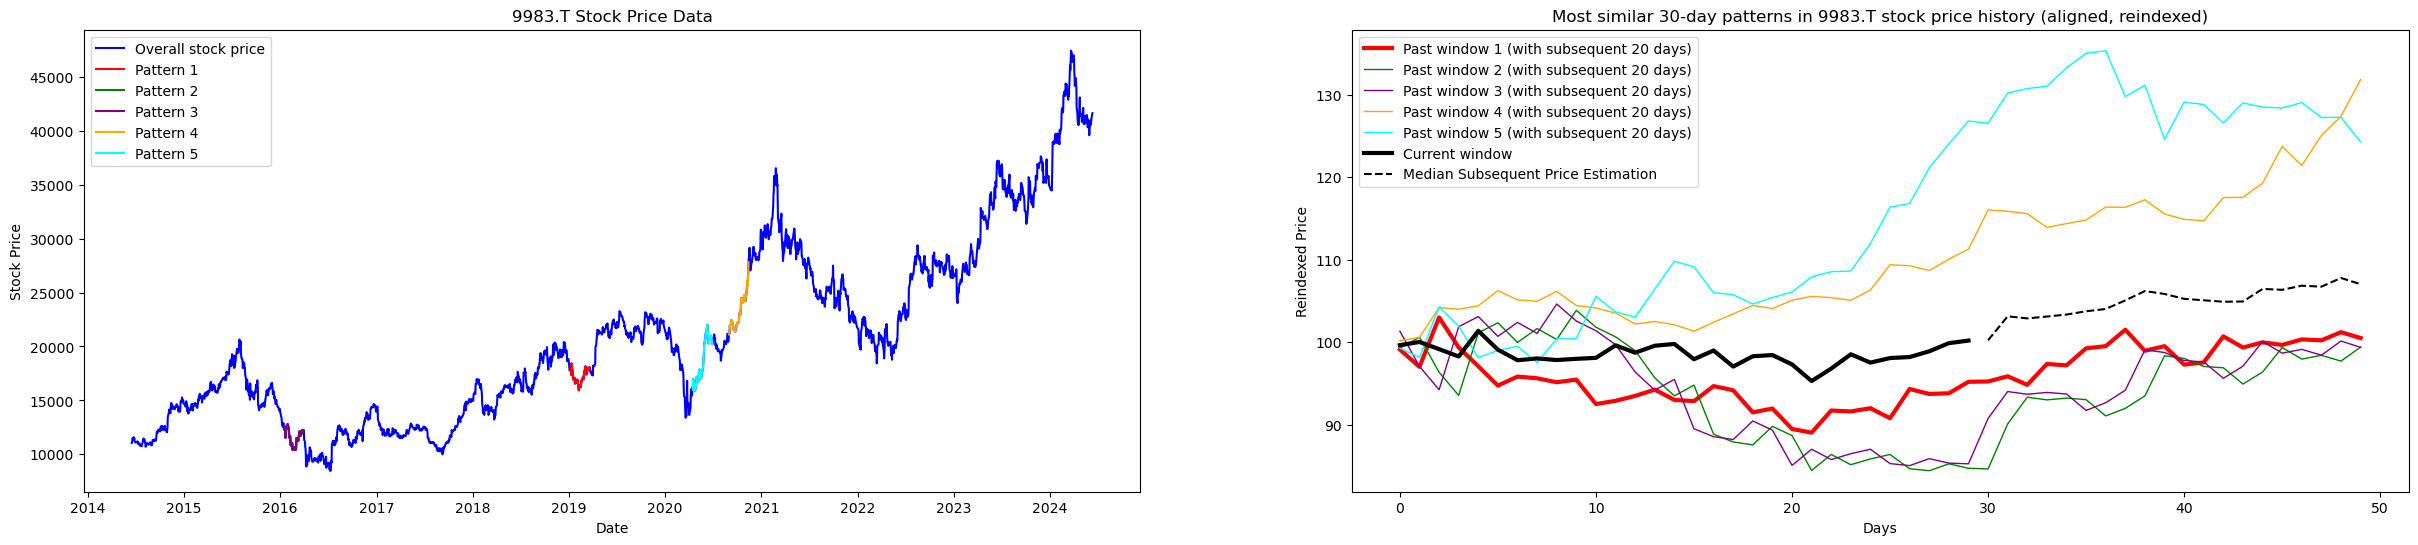

In [6]:
for n_days in days_to: 
    min_distances = find_most_similar_pattern(n_days)
    fig, axs = plt.subplots(1, 2, figsize=(30, 6))
    # 株価過去データの描画
    axs[0].plot(price_data, color='blue', label='Overall stock price')
    color_cycle = ['red', 'green', 'purple', 'orange', 'cyan']
    subsequent_prices = []

    # 類似パターンとして抽出された部分を色を変えて再描画する
    for i, (_, start_index) in enumerate(min_distances):
        color = color_cycle[i % len(color_cycle)]
        past_window_start_date = price_data.index[start_index]
        past_window_end_date = price_data.index[start_index + n_days + subsequent_days]
        axs[0].plot(price_data[past_window_start_date:past_window_end_date], color=color, label=f"Pattern {i + 1}")
        # Store subsequent prices for median calculation
        subsequent_window = price_data_pct_change[start_index + n_days : start_index + n_days + subsequent_days].values
        subsequent_prices.append(subsequent_window)

    axs[0].set_title(f'{ticker} Stock Price Data')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Stock Price')
    axs[0].legend()

    # 類似パターンの描画：pct_change()により変換された変化率の時系列は、(各要素+1)にcumprod()を適用することにより元に戻す
    for i, (_, start_index) in enumerate(min_distances):
        color = color_cycle[i % len(color_cycle)]
        past_window = price_data_pct_change[start_index:start_index + n_days + subsequent_days]
        reindexed_past_window = (past_window + 1).cumprod() * 100
        axs[1].plot(range(n_days + subsequent_days), reindexed_past_window, color=color, linewidth=3 if i == 0 else 1, label=f"Past window {i + 1} (with subsequent {subsequent_days} days)")

    # 実際の株価パターンを類似パターンの図に埋め込む
    reindexed_current_window = (price_data_pct_change[-n_days:] + 1).cumprod() * 100
    axs[1].plot(range(n_days), reindexed_current_window, color='k', linewidth=3, label="Current window")
    
    # 5つの予測パターンの中央値を計算して描画する
    subsequent_prices = np.array(subsequent_prices)
    median_subsequent_prices = np.median(subsequent_prices, axis=0)
    median_subsequent_prices_cum = (median_subsequent_prices + 1).cumprod() * reindexed_current_window.iloc[-1]
    
    axs[1].plot(range(n_days, n_days + subsequent_days), median_subsequent_prices_cum, color='black', linestyle='dashed', label="Median Subsequent Price Estimation")
    axs[1].set_title(f"Most similar {n_days}-day patterns in {ticker} stock price history (aligned, reindexed)")
    axs[1].set_xlabel("Days")
    axs[1].set_ylabel("Reindexed Price")
    axs[1].legend()

    #plt.show()
    figname = 'DTW_demo_'+str(n_days)+'days.png'
    plt.savefig(figname)